In [1]:
treeTermPath <- '/fs/cbcb-lab/rob/students/noor/Uncertainity/treeTerminusScripts'
suppressPackageStartupMessages(source(file.path(treeTermPath, "tree_helper_function.R")))
suppressPackageStartupMessages(source(file.path(treeTermPath, "tree_term_climb.R")))
suppressPackageStartupMessages(library(beaveR))

seed <- 10
mainDir <- "/fs/cbcb-lab/rob/students/noor/Uncertainity/brain_sim_null/post_type=gibbs_nrep=100_tf=100"
clustFile <- file.path(mainDir, "terminus", paste("seed",seed,sep="="), "no_threshold0", "cluster_nwk.txt")
quantDir <- file.path(mainDir, "out_sal", paste("seed",seed,sep="="))
samples <- as.vector(outer(c(1:6), c(1,2), function(x,y) paste(x,y,sep='_')))
quantFiles <- file.path(quantDir, samples, 'quant.sf')
coldata <- data.frame(files=quantFiles, names=samples, condition=factor(rep(1:2, each=6)))

tse <- buildTSE(treeTermFile = clustFile, coldata = coldata)
tree <- rowTree(tse)
nl <- length(tree$tip)

reading tree

importing quantifications

reading in files with read_tsv

1 
2 
3 
4 
5 
6 
7 
8 
9 
10 
11 
12 


found matching transcriptome:
[ GENCODE - Homo sapiens - release 26 ]

loading existing TxDb created: 2023-03-02 17:08:07

Loading required package: GenomicFeatures

Loading required package: AnnotationDbi

loading existing transcript ranges created: 2023-03-02 21:45:10

Missing txps 3894

Aggregation Started

Aggregation Ended



In [4]:
gse <- summarizeToGene(tse)
txpGene <- SummarizedExperiment(assays= list(counts = rbind(assays(tse)[["counts"]][1:nl,], assays(gse)[["counts"]]),
                                           length = rbind(assays(tse)[["length"]][1:nl,], assays(gse)[["length"]]),
                                           abundance = rbind(assays(tse)[["abundance"]][1:nl,], assays(gse)[["abundance"]])), 
                                   colData = colData(tse),
                                   )

dim(txpGene)
for(i in seq(100)) {
    inf <- paste("infRep", i, sep = "")
    assays(txpGene)[[inf]] <- rbind(assays(tse)[[inf]][1:nl,], assays(gse)[[inf]])
}
metadata(txpGene)[["txpsAnn"]] <- metadata(tse)[["txpsAnn"]]
metadata(txpGene)[["infRepsScaled"]] <- FALSE

loading existing TxDb created: 2023-03-02 17:08:07

obtaining transcript-to-gene mapping from database

loading existing gene ranges created: 2023-03-02 17:08:18

transcripts missing from tx2gene: 116168

summarizing abundance

summarizing counts

summarizing length

summarizing inferential replicates



[1] 160797     12

In [5]:
cSF <- function (tse, type = "txp", lengthCorrect = TRUE, meanDepth = NULL, 
    sfFun = NULL, minCount = 10, minN = 3, quiet = FALSE, force = FALSE) 
{
    metadata(tse)[["type"]] <- type
    l <- nrow(metadata(tse)[["txpsAnn"]])
    
    tseT <- tse
    tseT <- tse[1:l, ]
    if (type == "gene") {
        gse <- summarizeToGene(tseT)
    }
    infRepIdx <- grep("infRep", assayNames(tse))
    counts <- if (type == "txp") 
        assays(tseT)[["counts"]]
    else assays(gse)[["counts"]]
    infReps <- if (type == "txp") 
        assays(tseT)[infRepIdx]
    else assays(gse)[infRepIdx]
    length <- if (type == "txp") 
        assays(tseT)[["length"]]
    else assays(gse)[["length"]]
    nreps <- length(infReps)
    if (is.null(meanDepth) & is.null(sfFun)) {
        meanDepth <- exp(mean(log(colSums(counts))))
    }
    sizeMat <- matrix(nrow = nreps, ncol = ncol(tse))
    if (is.null(length)) {
        if (lengthCorrect) {
            if (!quiet) 
                message("not correcting for feature length (lengthCorrect=FALSE)")
        }
        lengthCorrect <- FALSE
    }
    for (k in seq_len(nreps)) {
        if (!quiet) 
            svMisc::progress(k, max.value = nreps, init = (k == 
                1), gui = FALSE)
        if (lengthCorrect) {
            length <- length/exp(rowMeans(log(length)))
            cts <- infReps[[k]]/length
        }
        else {
            cts <- infReps[[k]]
        }
        if (is.null(sfFun)) {
            cts <- t(t(cts)/colSums(cts)) * meanDepth
            use <- rowSums(infReps[[k]] >= minCount) >= minN
            loggeomeans <- rowMeans(log(cts[use, ]))
            sf <- apply(cts[use, ], 2, function(s) {
                exp(median((log(s) - loggeomeans)[is.finite(loggeomeans)]))
            })
        }
        else {
            sf <- sfFun(cts)
        }
        infReps[[k]] <- t(t(cts)/sf)
        sizeMat[k, ] <- sf
    }
    metadata(tse)$sf <- sizeMat
    tse
}

#### All together

In [6]:
yG <- cSF(txpGene)
dim(yG)
yG <- scaleInfReps(yG)
dim(yG)
set.seed(10)
yG <- labelKeep(yG)
out <- swish(yG, x="condition", returnNulls = TRUE)

Progress:   1 on 100Progress:   2 on 100Progress:   3 on 100Progress:   4 on 100Progress:   5 on 100Progress:   6 on 100Progress:   7 on 100Progress:   8 on 100Progress:   9 on 100Progress:  10 on 100Progress:  11 on 100Progress:  12 on 100Progress:  13 on 100Progress:  14 on 100Progress:  15 on 100Progress:  16 on 100Progress:  17 on 100Progress:  18 on 100Progress:  19 on 100Progress:  20 on 100Progress:  21 on 100Progress:  22 on 100Progress:  23 on 100Progress:  24 on 100Progress:  25 on 100Progress:  26 on 100Progress:  27 on 100Progress:  28 on 100Progress:  29 on 100Progress:  30 on 100Progress:  31 on 100Progress:  32 on 100Progress:  33 on 100Progress:  34 on 100Progress:  35 on 100Progress:  36 on 100Progress:  37 on 100Progress:  38 on 100Progress:  39 on 100Progress:  40 on 100Progress:  41 on 100Progress:  42 on 100Progress:  43 on 100Progress:  44 on 100Progress:  45 on 100Progress:  46 on 100Progress:  47 on 100Progress:  48 on 100Progress:  49 on 100Progress:  50 on 100

[1] 160797     12

Setting inf rep depth to mean depth



Progress:   1 on 100Progress:   2 on 100Progress:   3 on 100Progress:   4 on 100Progress:   5 on 100Progress:   6 on 100Progress:   7 on 100Progress:   8 on 100Progress:   9 on 100Progress:  10 on 100Progress:  11 on 100Progress:  12 on 100Progress:  13 on 100Progress:  14 on 100Progress:  15 on 100Progress:  16 on 100Progress:  17 on 100Progress:  18 on 100Progress:  19 on 100Progress:  20 on 100Progress:  21 on 100Progress:  22 on 100Progress:  23 on 100Progress:  24 on 100Progress:  25 on 100Progress:  26 on 100Progress:  27 on 100Progress:  28 on 100Progress:  29 on 100Progress:  30 on 100Progress:  31 on 100Progress:  32 on 100Progress:  33 on 100Progress:  34 on 100Progress:  35 on 100Progress:  36 on 100Progress:  37 on 100Progress:  38 on 100Progress:  39 on 100Progress:  40 on 100Progress:  41 on 100Progress:  42 on 100Progress:  43 on 100Progress:  44 on 100Progress:  45 on 100Progress:  46 on 100Progress:  47 on 100Progress:  48 on 100Progress:  49 on 100Progress:  50 on 100

[1] 160797     12

In [11]:
rr <- rownames(yG)[mcols(yG)[["keep"]]]
gInds <- match(rr[grep("ENSG", rr)], rr)

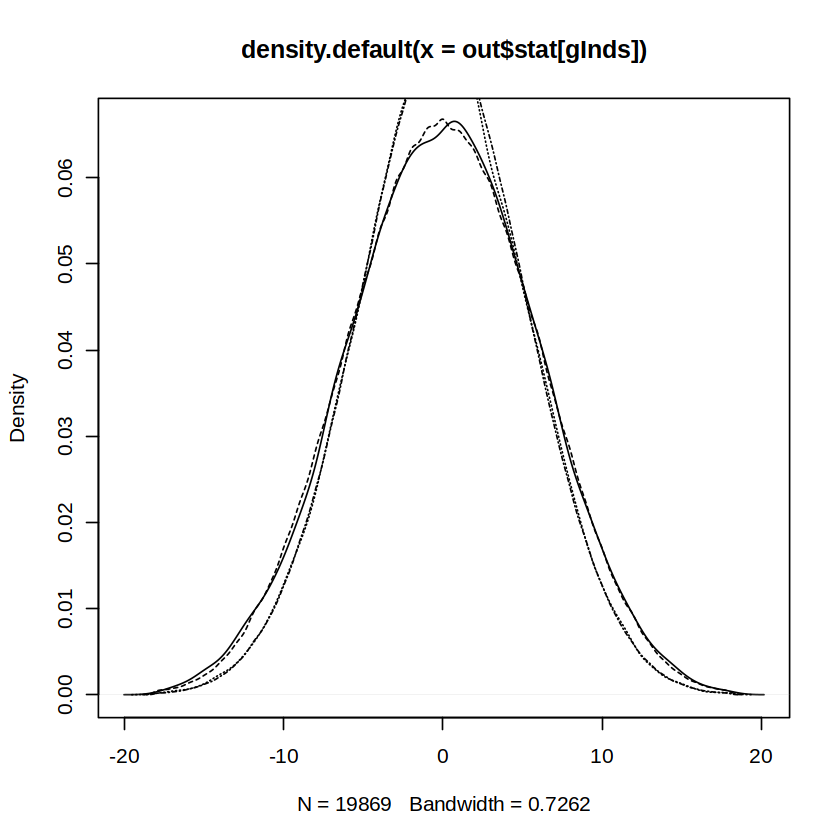

In [31]:
# plot(density(out$stat),type="l",lty=1);
# lines(density(as.vector(out$nulls)),lty=2)
plot(density(out$stat[gInds]),type="l",lty=1)
lines(density(as.vector(out$nulls[gInds,])),type="l",lty=2)
lines(density(as.vector(out$stat[1:gInds[1]-1])),lty=3)
lines(density(as.vector(out$nulls[1:gInds[1]-1,])),lty=4)


In [29]:
out$stat[1:gInds[1]-1]

[1]  -0.21  -2.73  -6.64  -2.04  -5.27  -0.06   0.19  -1.36  -3.65   0.81
   [11]  -6.66  -2.13   4.00  -4.30  -5.78   6.05   5.74   2.95   5.07   7.83
   [21]  -6.55   4.71  -3.34  -4.48   8.16   0.98   4.10  10.93  -1.30  -2.61
   [31]  -0.65  -7.14   7.06  -0.59   3.38  -0.11   2.34  -3.99  -0.51   2.56
   [41]   6.73   3.48  -0.54   6.68   5.89   0.51  13.18   1.22 -11.11   6.19
   [51]   3.90  -1.15   4.30   1.40   5.26  -4.10   5.27   9.57   7.07   0.12
   [61] -10.27   5.09   3.55   4.47   9.66   0.59   2.01   1.29   4.03  -6.88
   [71]   7.00   2.52  -8.96  -1.16   6.15  -0.81   8.85   0.91  -6.06 -11.69
   [81]  -2.62  -2.36   0.21   3.58  11.50  -4.11  -4.46  -2.67   1.81   0.24
   [91] -10.64  -5.51   0.57 -16.47  -2.91  -6.15   3.81   5.29   6.03   6.69
  [101]  12.77   1.78  12.46   0.64   0.78  -1.96   2.31  -8.48  -1.13  -3.83
  [111]   3.99  -1.43  -2.37  -0.17  -0.81  -2.82   2.40   2.07  -4.50   6.21
  [121]   4.85  -0.40  -0.91  -5.96  -9.34   3.90   3.48   1.07   3.17  -2.93
  [131]   9.89   3.44  -5.22   4.92  -0.49   0.02   5.17   7.32 -11.25  10.06
  [141]   5.71  -3.92   8.87   5.37   1.03  -0.49   2.32   4.36   1.97   1.25
  [151]  -2.82 -11.53   1.08  -3.78   3.38  -8.11 -16.84  -4.54  -1.08   3.45
  [161] -11.01  -2.13  -7.14  -4.54   3.38   3.33   6.03   7.33 -11.14   2.59
  [171]  -2.51  -2.13   0.78  -2.40   4.04  10.71  -8.49  -6.05  -1.95   0.48
  [181]   6.49   8.27   7.02   1.62   2.33  -0.63   4.54  -5.71   4.22  -1.28
  [191]   0.20  -5.41   6.52  -1.85  -3.43  -8.92  -0.67  -1.14   2.75 -13.91
  [201]   5.58   6.60  -1.86  -0.04  -5.19  14.09   1.55   1.29  -5.49   0.84
  [211]   2.97   1.05  -3.99   1.53  -2.34  -2.49   4.38   3.03 -10.27   8.46
  [221]   2.30   2.37  -6.59   1.33  -1.19  -5.28   2.37  -2.05 -11.44   9.79
  [231]  -1.37   4.50   6.28  -0.81   1.51  -7.04   0.60   3.26  -6.67   5.30
  [241]   1.23  -0.90  -0.38  -1.24   8.33   2.20  -7.86  -1.16  -3.75   3.90
  [251]  13.02  -5.07   3.25   1.70   7.87   4.20   1.39  -8.00   5.41  -0.28
  [261]   9.35  -4.87  -2.16   3.96  -2.48   8.51  -3.74   4.61  -2.60  -6.69
  [271]  -7.15  -0.15  -2.69   0.81   7.83  -4.91  -7.80  -3.67  -4.53  -1.32
  [281]  -1.80   1.73  -3.59   3.38   0.99  -0.09   1.73 -10.84  -6.91  -0.64
  [291]   0.80  -1.24   2.29   6.17   8.21   1.50   2.27   4.29   0.28  -3.06
  [301]  -0.78  -2.34   5.69   0.45   6.61   0.23  -3.59  -9.18  -2.98  -1.35
  [311]   3.03   3.59  -1.84   2.83  -2.63   0.47   3.70   0.12   0.72   6.90
  [321]  -7.72   3.80   0.35   1.97  -5.90   6.28  -4.66  -6.65   1.60   5.59
  [331]  -2.20  -0.03   4.32   2.17   7.89 -10.65   2.31   6.95   2.93  -2.14
  [341]   8.36   4.97  -9.48   6.28  -4.57   2.87  12.73  -3.38   0.39   1.75
  [351]  -7.42 -10.41  -0.97   4.20   1.33  15.71  -6.22   4.04  -2.70   2.84
  [361]  -8.73   1.48  -9.38   6.17  -5.40  -4.53  -2.71  -4.94   6.29  -2.65
  [371]   2.49  -2.63   1.25  -0.28  -0.98  10.17   5.34  -9.11 -10.24 -13.27
  [381]  -2.17   3.61  -2.16   7.40   7.75  10.57   9.78  -5.00  -2.71   3.08
  [391]  -0.40   4.27  -6.94  -7.35   4.71   1.68  -9.49  -4.11  -8.15  -8.59
  [401]  -1.81   3.26  -1.56   7.11  -4.58   6.74  -5.51  12.91  11.09  -5.03
  [411]  -5.54   1.52   6.39  -6.49  -6.84  -2.27  -2.08   2.69   6.98  11.44
  [421] -12.88   4.10  -2.15  -8.14   6.62   1.73  -2.09   1.21  -2.32  -4.32
  [431]  12.60   3.71  -1.57  -6.10  -1.49  -0.98  -1.42  -6.67  -2.79  -7.52
  [441]   0.03   9.60  -5.68  -1.93 -10.56  -4.11   0.89  -4.02  -4.61  -2.35
  [451]  -0.39   0.76 -10.93  -0.39   1.36  -0.91   1.45   3.91   1.91  -3.11
  [461]  -9.96   4.96   1.35   6.74  -7.08  -0.37   2.28   1.96  10.38   6.80
  [471]   1.53   2.85   2.32  -4.38   1.39   3.89  -4.05   0.63   2.28  -1.34
  [481]   0.73   5.67  -3.74   3.05  -4.76  10.38  -4.80 -10.81  -4.63  -4.22
  [491]  -4.24   3.18  -2.06   3.05  -2.55   0.02   1.44  -5.61  -4.57  10.12
  [501] -11.82   1.46   3.50  -1.03  -2.87  -6.73  -0.77   3.08   0.66   6.07
  [511]  -6.83  -2.45  -7.

In [ ]:
plot(density(out$stat)[gInds],type="l",lty=1);
lines(density(as.vector(out$nulls)),lty=2)

#### Only on Genes

In [7]:
gy <- fishpond::scaleInfReps(gse)
set.seed(10)
gy <- labelKeep(gy)
outGY <- swish(gy, x="condition", returnNulls = TRUE)

#### Only for txps

In [32]:
y <- fishpond::scaleInfReps(tse[1:nl,])
set.seed(10)
y <- labelKeep(y)
outTxps <- swish(y, x="condition", returnNulls = TRUE)

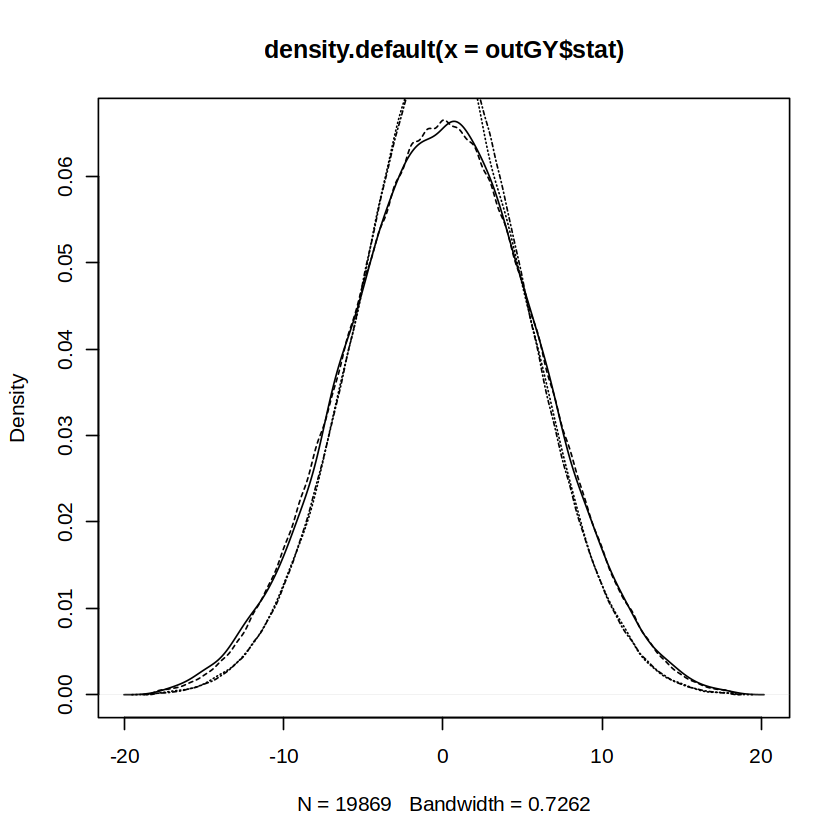

In [35]:
plot(density(outGY$stat),type="l",lty=1)
lines(density(as.vector(outGY$nulls)),type="l",lty=2)
# lines(density(as.vector(outTxps$stat)),lty=3)
# lines(density(as.vector(outTxps$nulls)),lty=4)